In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
from os.path import join
import os
from anndata import AnnData
from mudata import MuData
from muon import prot as pt

In [4]:
import celltypist
from celltypist import models
import scanpy as sc

In [5]:
!pwd

/Users/mkeller/research/dbmi/vitessce/paper-figures/cite-seq/src


In [6]:
BASE_DIR = join("..", "..", "hubmap-publication-page", "data")
VIGNETTE_DIR = join("..", "..", "hubmap-publication-page", "vignettes", "vignette_05")

In [7]:
#Download a list of models, for example, `Immune_All_Low.pkl` and `Immune_All_High.pkl`.
models.download_models(model = ['Immune_All_Low.pkl', 'Immune_All_High.pkl'])

📂 Storing models in /Users/mkeller/.celltypist/data/models
💾 Total models to download: 2
⏩ Skipping [1/2]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/2]: Immune_All_High.pkl (file exists)


In [8]:
rna_df = pd.read_csv(join("..", "data", "raw", "GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv.gz"))

In [9]:
rna_df = rna_df.rename(columns={'Unnamed: 0': "gene_id"})

In [10]:
rna_df = rna_df.loc[rna_df["gene_id"].str.startswith("HUMAN_")]

In [11]:
rna_df["gene_id"] = rna_df["gene_id"].apply(lambda gene_name: gene_name[len("HUMAN_"):])
rna_df = rna_df.set_index("gene_id")

In [13]:
adt_df = pd.read_csv(join("..", "data", "raw", "GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv.gz"), index_col=0)

In [14]:
rna_adata = AnnData(X=rna_df.T.values, obs=pd.DataFrame(index=rna_df.columns.values, data=[]), var=pd.DataFrame(index=rna_df.index.values, data=[]))
rna_adata

AnnData object with n_obs × n_vars = 8617 × 20400

In [15]:
adt_adata = AnnData(X=adt_df.T.values, obs=pd.DataFrame(index=adt_df.columns.values, data=[]), var=pd.DataFrame(index=adt_df.index.values, data=[]))
adt_adata

AnnData object with n_obs × n_vars = 8617 × 13

In [16]:
mdata = MuData({ "rna": rna_adata, "adt": adt_adata })
mdata

MuData object with n_obs × n_vars = 8617 × 20413
  2 modalities
    rna:	8617 x 20400
    adt:	8617 x 13

In [17]:
rna = mdata.mod["rna"]
adt = mdata.mod["adt"]

In [18]:
sc.pp.normalize_total(rna, target_sum=1e4)

In [19]:
sc.pp.log1p(rna)

In [20]:
sc.pp.highly_variable_genes(rna)

In [21]:
rna.raw = rna

In [22]:
rna = rna[:, rna.var.highly_variable]

In [23]:
sc.pp.scale(rna, max_value=10)

In [24]:
sc.tl.pca(rna, svd_solver='arpack')

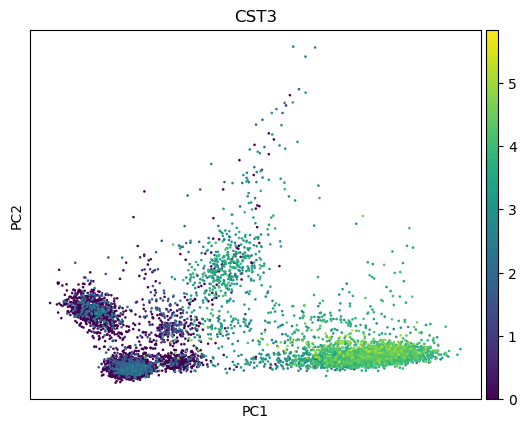

In [25]:
sc.pl.pca(rna, color='CST3')

In [26]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=30)

In [27]:
sc.tl.umap(rna)

In [28]:
sc.tl.leiden(rna)

In [29]:
mdata.mod["rna"] = rna

In [33]:
adt.X = adt.X.astype('float64')

In [34]:
pt.pp.clr(adt)

In [35]:
adt.obsm["X_umap"] = rna.obsm["X_umap"]
adt.obs["leiden"] = rna.obs["leiden"]

In [36]:
mdata

MuData object with n_obs × n_vars = 8617 × 20413
  2 modalities
    rna:	8617 x 2003
      obs:	'leiden'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    adt:	8617 x 13
      obs:	'leiden'
      obsm:	'X_umap'

In [37]:
mdata.write_zarr(join(BASE_DIR, "GSE100866_CBMC_8K_13AB_10X.mdata.zarr"))

In [38]:
from vitessce import (
    VitessceConfig,
    ViewType as vt,
    CoordinationType as ct,
    FileType as ft,
    AnnDataWrapper,
    BASE_URL_PLACEHOLDER
)
from vitessce.data_utils import VAR_CHUNK_SIZE
import json
from os.path import join

In [39]:
from anndata import read_zarr

In [40]:
rna_zarr = join("GSE100866_CBMC_8K_13AB_10X.mdata.zarr", "mod", "rna")
adt_zarr = join("GSE100866_CBMC_8K_13AB_10X.mdata.zarr", "mod", "adt")

In [41]:
rna_adata = read_zarr(join(BASE_DIR, rna_zarr))
rna_adata

AnnData object with n_obs × n_vars = 8617 × 2003
    obs: 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [42]:
adt_adata = read_zarr(join(BASE_DIR, adt_zarr))
adt_adata

AnnData object with n_obs × n_vars = 8617 × 13
    obs: 'leiden'
    obsm: 'X_umap'

In [43]:
adata = rna_adata
low_predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True)
adata = low_predictions.to_adata(prefix="low_")
high_predictions = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)
adata = high_predictions.to_adata(prefix="high_")

👀 Detected scaled expression in the input data, will try the .raw attribute
🔬 Input data has 8617 cells and 20400 genes
🔗 Matching reference genes in the model
🧬 5062 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
👀 Detected scaled expression in the input data, will try the .raw attribute
🔬 Input data has 8617 cells and 20400 genes
🔗 Matching reference genes in the model
🧬 5062 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [44]:
adata.write_zarr(join(BASE_DIR, rna_zarr), chunks=(adata.shape[0], VAR_CHUNK_SIZE))

In [45]:
adata

AnnData object with n_obs × n_vars = 8617 × 2003
    obs: 'leiden', 'low_predicted_labels', 'low_over_clustering', 'low_majority_voting', 'low_conf_score', 'high_predicted_labels', 'high_over_clustering', 'high_majority_voting', 'high_conf_score'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [46]:
adt_adata.obs["low_majority_voting"] = adata.obs["low_majority_voting"]
adt_adata.obs["high_majority_voting"] = adata.obs["high_majority_voting"]

In [47]:
adt_adata.write_zarr(join(BASE_DIR, adt_zarr), chunks=(adt_adata.shape[0], VAR_CHUNK_SIZE))

In [101]:
vc = VitessceConfig(schema_version="1.0.15", name='CITE-seq example', description='RNA+ADT', base_dir=BASE_DIR)

In [102]:
dataset = vc.add_dataset(name='CBMC 8K').add_object(AnnDataWrapper(
    # We run add_object with adata_path=rna_zarr first to add the cell-by-gene matrix and associated metadata.
    adata_path=rna_zarr,
    obs_embedding_paths=["obsm/X_umap", "obsm/X_pca"],
    obs_embedding_names=["UMAP", "PCA"],
    obs_set_paths=["obs/leiden", ["obs/high_majority_voting", "obs/low_majority_voting"]],
    obs_set_names=["Leiden Clusters", "Predicted Cell Type"],
    obs_feature_matrix_path="X",
    # To be explicit that the features represent genes and gene expression, we specify that here.
    coordination_values={
        "featureType": "gene",
        "featureValueType": "expression"
    }
)).add_object(AnnDataWrapper(
    # We next run add_object with adata_path=adt_zarr to add the cell-by-ADT matrix and associated metadata.
    adata_path=adt_zarr,
    obs_embedding_paths=["obsm/X_umap"],
    obs_embedding_names=["UMAP"],
    obs_set_paths=["obs/leiden", ["obs/high_majority_voting", "obs/low_majority_voting"]],
    obs_set_names=["Leiden Clusters", "Predicted Cell Type"],
    obs_feature_matrix_path="X",
    # If the features do not represent genes and gene expression, we specify alternate values here.
    coordination_values={
        "featureType": "tag",
        "featureValueType": "count"
    }
))

In [103]:
umap_scatterplot_by_rna = vc.add_view(vt.SCATTERPLOT, dataset=dataset, mapping="UMAP", x=6, y=0, w=3, h=6)
umap_scatterplot_by_adt = vc.add_view(vt.SCATTERPLOT, dataset=dataset, mapping="UMAP", x=6, y=6, w=3, h=6)

gene_list = vc.add_view(vt.FEATURE_LIST, dataset=dataset, x=9, y=0, w=3, h=4)
protein_list = vc.add_view(vt.FEATURE_LIST, dataset=dataset, x=9, y=8, w=3, h=4)

obs_sets = vc.add_view(vt.OBS_SETS, dataset=dataset, x=9, y=4, w=3, h=4)

rna_heatmap = vc.add_view(vt.HEATMAP, dataset=dataset, x=0, y=0, w=6, h=6).set_props(transpose=True)
adt_heatmap = vc.add_view(vt.HEATMAP, dataset=dataset, x=0, y=6, w=6, h=6).set_props(transpose=True)

In [104]:
# We need to specify which of the two features (i.e., genes or tags) the different plots correspond to.
# We also need to make sure the selection of genes and tags are scoped to only the corresponding plots,
# and we want to make sure the color mappings are independent for each modality.
all_views = [
    umap_scatterplot_by_rna, gene_list, rna_heatmap,
    umap_scatterplot_by_adt, protein_list, adt_heatmap,
    obs_sets,
]
coordination_types = [ct.FEATURE_TYPE, ct.FEATURE_VALUE_TYPE, ct.FEATURE_SELECTION, ct.OBS_COLOR_ENCODING, ct.FEATURE_VALUE_COLORMAP_RANGE]
vc.link_views([umap_scatterplot_by_rna, gene_list, rna_heatmap], coordination_types, ["gene", "expression", ["GZMB"], 'geneSelection', [0.0, 0.3]])
vc.link_views([umap_scatterplot_by_adt, protein_list, adt_heatmap], coordination_types, ["tag", "count", ["CD56"], 'geneSelection', [0.0, 0.5]])

# We can link the two scatterplots on their zoom level and (X,Y) center point so that zooming/panning is coordinated.
vc.link_views([umap_scatterplot_by_rna, umap_scatterplot_by_adt], [ct.EMBEDDING_ZOOM, ct.EMBEDDING_TARGET_X, ct.EMBEDDING_TARGET_Y], [3, 8, -3])

vc.link_views([umap_scatterplot_by_rna, umap_scatterplot_by_adt], [ct.EMBEDDING_OBS_SET_LABELS_VISIBLE], [True])
vc.link_views(all_views, [ct.OBS_SET_SELECTION], [[
    ["Predicted Cell Type", "ILC", "CD16- NK cells"],
    ["Predicted Cell Type", "ILC", "CD16+ NK cells"],
    ["Predicted Cell Type", "ILC", "Classical monocytes"],
    ["Predicted Cell Type", "ILC", "NK cells"],
]])

In [105]:
# We define a layout for the plots using two rows.
# In the first row, we add the three gene-related visualizations,
# and in the second row, we add the three ADT-related visualizations.
"""
vc.layout(
    (rna_heatmap | (umap_scatterplot_by_rna | gene_list))
    / (adt_heatmap | (umap_scatterplot_by_adt | protein_list))
);
"""

'\nvc.layout(\n    (rna_heatmap | (umap_scatterplot_by_rna | gene_list))\n    / (adt_heatmap | (umap_scatterplot_by_adt | protein_list))\n);\n'

In [106]:
#vw = vc.widget()
#vw

In [107]:
vc.web_app()

'http://vitessce.io/#?theme=light&url=data:,%7B%22version%22%3A+%221.0.15%22%2C+%22name%22%3A+%22CITE-seq+example%22%2C+%22description%22%3A+%22RNA%2BADT%22%2C+%22datasets%22%3A+%5B%7B%22uid%22%3A+%22A%22%2C+%22name%22%3A+%22CBMC+8K%22%2C+%22files%22%3A+%5B%7B%22fileType%22%3A+%22anndata.zarr%22%2C+%22url%22%3A+%22http%3A%2F%2Flocalhost%3A8017%2FGSE100866_CBMC_8K_13AB_10X.mdata.zarr%2Fmod%2Frna%22%2C+%22options%22%3A+%7B%22obsEmbedding%22%3A+%5B%7B%22path%22%3A+%22obsm%2FX_umap%22%2C+%22dims%22%3A+%5B0%2C+1%5D%2C+%22embeddingType%22%3A+%22UMAP%22%7D%2C+%7B%22path%22%3A+%22obsm%2FX_pca%22%2C+%22dims%22%3A+%5B0%2C+1%5D%2C+%22embeddingType%22%3A+%22PCA%22%7D%5D%2C+%22obsSets%22%3A+%5B%7B%22name%22%3A+%22Leiden+Clusters%22%2C+%22path%22%3A+%22obs%2Fleiden%22%7D%2C+%7B%22name%22%3A+%22Predicted+Cell+Type%22%2C+%22path%22%3A+%5B%22obs%2Fhigh_majority_voting%22%2C+%22obs%2Flow_majority_voting%22%5D%7D%5D%2C+%22obsFeatureMatrix%22%3A+%7B%22path%22%3A+%22X%22%7D%7D%2C+%22coordinationValues%22%3

In [ ]:
os.makedirs(VIGNETTE_DIR, exist_ok=True)

In [ ]:
config_dict = vc.to_dict(base_url=BASE_URL_PLACEHOLDER)

# Use `open` to create a new empty file at ./exported_data/vitessce.json
with open(join(VIGNETTE_DIR, "cite-seq.json"), "w") as f:
    json.dump(config_dict, f)


In [ ]:
vignette_md = """---
name: Use Case 5
figures:
    - name: "Visualization"
      file: cite-seq.json
---

## Transcriptomics and surface protein abundance in human cord blood mononuclear cells

Stoeckius et al. report the development of the CITE-seq method for measuring gene expression and surface protein abundance in the same cells (Stoeckius et al., Nature Methods 2017). The authors validate their technique on a sample of cord blood mononuclear cells (CBMCs) by measuring the abundance of well-characterized immune cell type markers. Using linked scatterplots and heatmaps to visualize protein abundance and gene expression levels simultaneously, we can reproduce the authors’ multimodal characterization of the Natural Killer (NK) cell type based on CD56 levels and the expression of genes GZMB, GZMK, and PRF1.

"""

with open(join(VIGNETTE_DIR, "description.md"), "w") as f:
    f.write(vignette_md)
